# Random Forest Regression

## 1. Veri Hazırlama ve Temizleme

Veriyi yüklüyoruz.
Eksik verileri temizliyoruz.
Gerekli dönüşümleri uyguluyoruz.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Veri setini indir ve oku
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
df = pd.read_excel(url, sheet_name="Online Retail")

# Eksik verileri temizle (CustomerID olmayanları çıkar)
df = df.dropna(subset=["CustomerID"])

# Negatif veya sıfır Quantity ve UnitPrice değerlerini çıkar
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Yeni hedef değişkeni (TotalPrice)
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# InvoiceDate'i datetime formatına çevir
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

## 2. Özellik (Feature) Mühendisliği

- InvoiceDate’i sin ve cos dönüşümleri ile zamansal döngüselliği yakalıyoruz.
- Country değişkenini sayısal hale getiriyoruz.
- TotalPrice değerini hesaplıyoruz (Quantity × UnitPrice).

In [ ]:
# Aylık sin/cos dönüşümleri
df["Month"] = df["InvoiceDate"].dt.month
df["Month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
df["Month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)

# Country değişkenini kategorik özellik olarak tanimla
df["Country"] = df["Country"].astype(str)
le = LabelEncoder()
df["Country_Encoded"] = le.fit_transform(df["Country"])

# Kullanılacak özellikler
features = [
    "Quantity",
    "UnitPrice",
    "Month_sin",
    "Month_cos",
    "Country_Encoded"
]
target = "TotalPrice"

X = df[features]
y = df[target]

# Eğitim & test kümelerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 3. Model Eğitimi

- Random Forest Regressor modelini eğitiyoruz.
- n_estimators = 200, min_samples_split = 10 olarak ayarlıyoruz.

In [30]:
# Random Forest Modeli (n_estimators=200, min_samples_split=10, max_features="sqrt")
rf = RandomForestRegressor(n_estimators=200, min_samples_split=10, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_split=10, n_estimators=200, random_state=42)

## 4. Model Değerlendirme ve Sonuçlar

- RMSE’yi hesaplıyoruz ve baz model ile karşılaştırıyoruz.
- Gerçek vs. Tahmin edilen değerleri görselleştiriyoruz.

Optimized Model RMSE: 12.45
Baseline RMSE: 76.71
Modelimiz, rastgele bir ortalama tahmininden çok daha iyi performans gösteriyor.


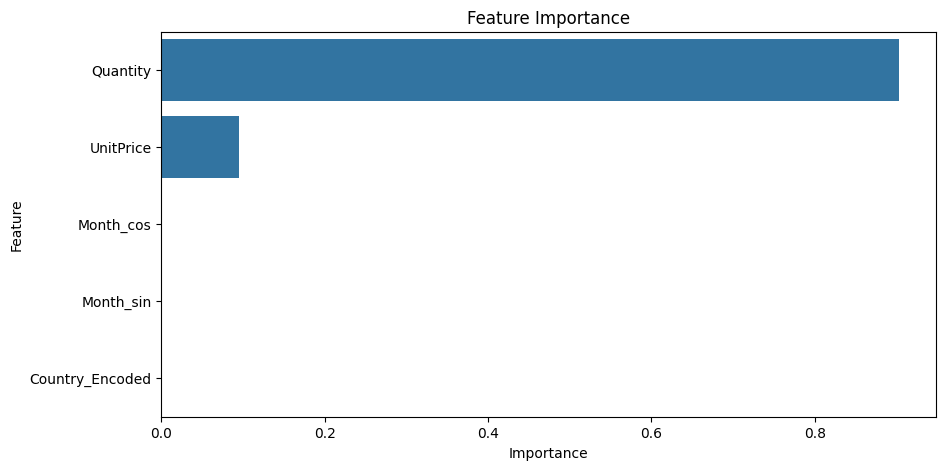

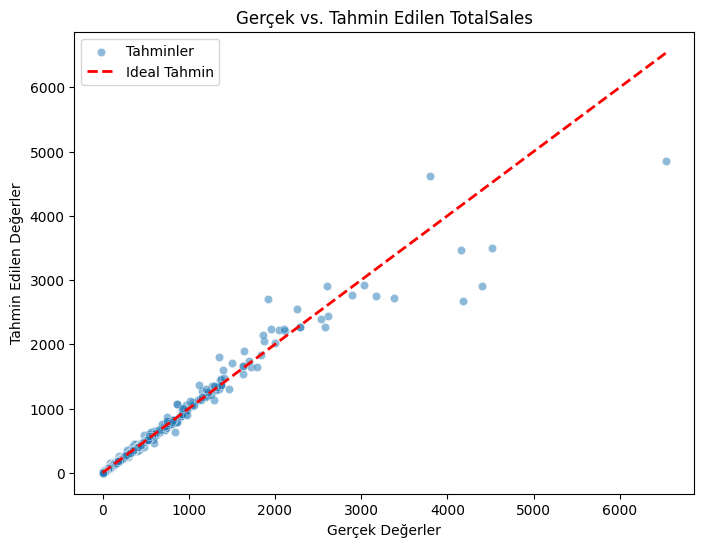

In [ ]:
# Tahmin yap
y_pred = rf.predict(X_test)

# RMSE hesapla
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Baseline Model: Ortalama tahmin
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

# Sonuçları yazdır
print(f"Optimized Model RMSE: {rmse:.2f}")
print(f"Baseline RMSE: {baseline_rmse:.2f}")
print("Modelimiz, rastgele bir ortalama tahmininden çok daha iyi performans gösteriyor.")

# Özellik Önem Düzeyleri
feature_importances = pd.DataFrame({
    "Feature": features,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importances)
plt.title("Feature Importance")
plt.show()

# Gerçek vs. Tahmin edilen görselleştirme
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, label="Tahminler")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Ideal Tahmin")
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin Edilen Değerler")
plt.title("Gerçek vs. Tahmin Edilen TotalPrice")
plt.legend()
plt.show()

## AÇIKLAMALAR:

1. InvoiceDate’i sin ve cos’a çevirmek neden önemli?
    - Aylık döngüsellikleri daha iyi yakalamak için kullanılır. Örneğin, yaz aylarında veya yıl sonunda satışlar artabilir.

2. Country değişkenini kategorik olarak encode etmek neden gerekli?
    - Modelin farklı ülkelerdeki satış trendlerini öğrenmesini sağlar. 

3. Bu modeli tedarik zinciri uygulamalarında nasıl kullanabiliriz?
    - **Tedarikçiler** için aylık satış tahminleri oluşturup stok yönetimini optimize edebiliriz.
    - **Satış ekibi**, belirli dönemlerde hangi ürünlerin daha fazla satılacağını önceden tahmin edebilir.
    - **Depo yönetimi**, mevsimsel dalgalanmaları öngörerek envanteri daha verimli yönetebilir.
    - **Dinamik fiyatlandırma**, Örneğin, yaz aylarında daha çok satılan ürünlerin fiyatlarını optimize ederek kârlılık arttırılabilir.